# 모형 최적화

머신 러닝 모형이 완성된 후에는 최적화 과정을 통해 예측 성능을 향상시킨다.

## Scikit-Learn 의 모형 하이퍼 파라미터 튜닝 도구

Scikit-Learn에서는 다음과 같은 모형 최적화 도구를 지원한다.

* [`validation_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)
  * 단일 하이퍼 파라미터 최적화
* [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
  * 그리드를 사용한 복수 하이퍼 파라미터 최적화
* [`ParameterGrid`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html)  
 * 복수 파라미터 최적화용 그리드


## `validation_curve` 

`validation_curve` 함수는 최적화할 파라미터 이름과 범위, 그리고 성능 기준을 `param_name`, `param_range`, `scoring` 인수로 받아 파라미터 범위의 모든 경우에 대해 성능 기준을 계산한다.

In [1]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

digits = load_digits()
X, y = digits.data, digits.target

param_range = np.logspace(-6, -1, 10)

In [2]:
%%time
train_scores, test_scores = \
    validation_curve(SVC(), X, y,
                     param_name="gamma", param_range=param_range,
                     cv=10, scoring="accuracy", n_jobs=1)

CPU times: user 53.1 s, sys: 110 ms, total: 53.2 s
Wall time: 54.1 s


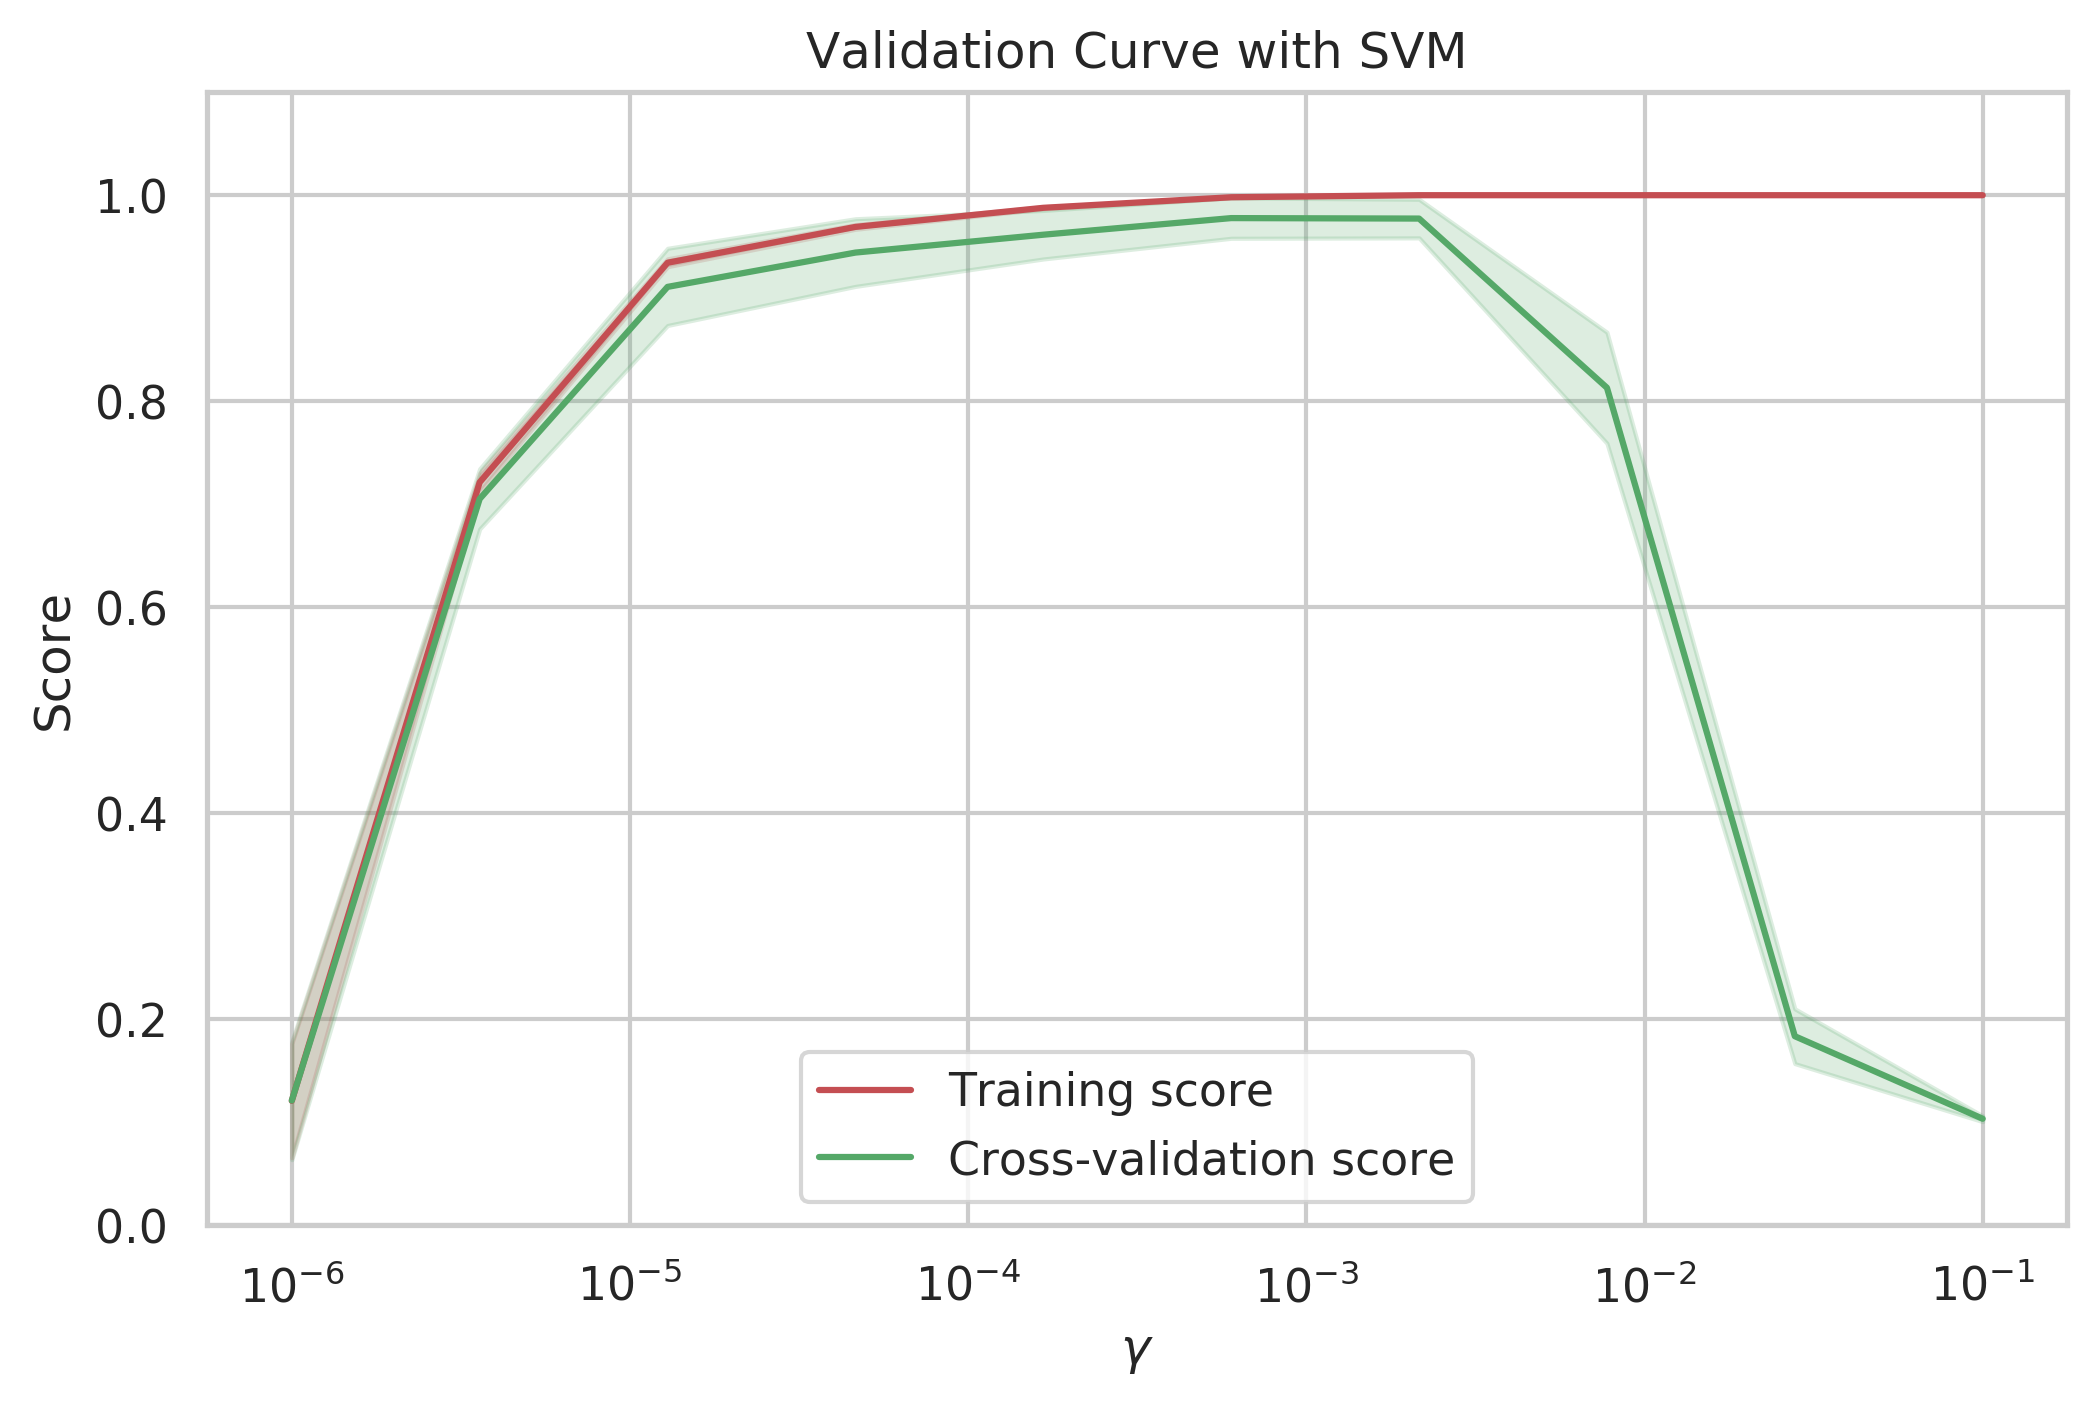

In [3]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

mpl.rcParams["font.family"] = 'DejaVu Sans'
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean,
             label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.show()

## `GridSearchCV` 

`GridSearchCV`  클래스는 `validation_curve` 함수와 달리 모형 래퍼(Wrapper) 성격의 클래스이다.  클래스 객체에 `fit` 메서드를 호출하면 grid search를 사용하여 자동으로 복수개의 내부 모형을 생성하고 이를 모두 실행시켜서 최적 파라미터를 찾아준다. 생성된 복수개와 내부 모형과 실행 결과는 다음 속성에 저장된다.

* `grid_scores_ `
 * param_grid 의 모든 파리미터 조합에 대한 성능 결과. 각각의 원소는 다음 요소로 이루어진 튜플이다.
  * parameters: 사용된 파라미터
  * mean_validation_score: 교차 검증(cross-validation) 결과의 평균값
  * cv_validation_scores: 모든 교차 검증(cross-validation) 결과
* `best_score_` 
 * 최고 점수 
* `best_params_`
 * 최고 점수를 낸 파라미터
* `best_estimator_`
 * 최고 점수를 낸 파라미터를 가진 모형

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'clf__C': param_range, 'clf__kernel': ['linear']},
    {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=10, n_jobs=1)
%time gs = gs.fit(X, y)

CPU times: user 9min 58s, sys: 16.2 s, total: 10min 15s
Wall time: 4min 13s


/home/dockeruser/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [5]:
gs.cv_results_["params"]

[{'clf__C': 0.0001, 'clf__kernel': 'linear'},
 {'clf__C': 0.001, 'clf__kernel': 'linear'},
 {'clf__C': 0.01, 'clf__kernel': 'linear'},
 {'clf__C': 0.1, 'clf__kernel': 'linear'},
 {'clf__C': 1.0, 'clf__kernel': 'linear'},
 {'clf__C': 10.0, 'clf__kernel': 'linear'},
 {'clf__C': 100.0, 'clf__kernel': 'linear'},
 {'clf__C': 1000.0, 'clf__kernel': 'linear'},
 {'clf__C': 0.0001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 1.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 10.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 100.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 1000.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.001, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'},
 {'clf__C

In [6]:
gs.cv_results_["mean_test_score"]

array([0.20868114, 0.91819699, 0.95269894, 0.95826377, 0.95826377,
       0.95826377, 0.95826377, 0.95826377, 0.11908737, 0.12020033,
       0.1213133 , 0.10350584, 0.10127991, 0.11185309, 0.10183639,
       0.10127991, 0.11908737, 0.12020033, 0.1213133 , 0.10350584,
       0.10127991, 0.11185309, 0.10183639, 0.10127991, 0.11908737,
       0.12020033, 0.13967724, 0.10350584, 0.10127991, 0.11185309,
       0.10183639, 0.10127991, 0.11908737, 0.68614357, 0.91207568,
       0.40567613, 0.10127991, 0.11185309, 0.10183639, 0.10127991,
       0.70339455, 0.93266555, 0.9638286 , 0.90984975, 0.11908737,
       0.10127991, 0.10127991, 0.10127991, 0.934335  , 0.95659432,
       0.97161937, 0.9115192 , 0.12966055, 0.10127991, 0.10127991,
       0.10127991, 0.95548136, 0.96160267, 0.97161937, 0.9115192 ,
       0.12966055, 0.10127991, 0.10127991, 0.10127991, 0.95993322,
       0.96215915, 0.97161937, 0.9115192 , 0.12966055, 0.10127991,
       0.10127991, 0.10127991])

In [7]:
print(gs.best_score_)
print(gs.best_params_)

0.9716193656093489
{'clf__C': 10.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


## `ParameterGrid` 

때로는 scikit-learn 이 제공하는 GridSearchCV 이외의 방법으로 그리드 탐색을 해야하는 경우도 있다. 이 경우 파라미터를 조합하여 탐색 그리드를 생성해 주는 명령어가 `ParameterGrid` 이다. `ParameterGrid` 는 탐색을 위한 iterator 역할을 한다.

In [8]:
from sklearn.model_selection import ParameterGrid

In [9]:
param_grid = {'a': [1, 2], 'b': [True, False]}
list(ParameterGrid(param_grid))

[{'a': 1, 'b': True},
 {'a': 1, 'b': False},
 {'a': 2, 'b': True},
 {'a': 2, 'b': False}]

In [10]:
param_grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': [1, 10]}]
list(ParameterGrid(param_grid))

[{'kernel': 'linear'},
 {'gamma': 1, 'kernel': 'rbf'},
 {'gamma': 10, 'kernel': 'rbf'}]

## 병렬 처리

`GridSearchCV` 명령에는 `n_jobs` 라는 인수가 있다. 디폴트 값은 1인데 이 값을 증가시키면 내부적으로 멀티 프로세스를 사용하여 그리드서치를 수행한다. 만약 CPU 코어의 수가 충분하다면 `n_jobs`를 늘릴 수록 속도가 증가한다.

In [11]:
param_grid = {"gamma": np.logspace(-6, -1, 10)}
gs1 = GridSearchCV(estimator=SVC(), param_grid=param_grid,
                   scoring='accuracy', cv=5, n_jobs=1)
gs2 = GridSearchCV(estimator=SVC(), param_grid=param_grid,
                   scoring='accuracy', cv=5, n_jobs=2)

In [12]:
%%time
gs1.fit(X, y)

CPU times: user 13.6 s, sys: 410 ms, total: 14 s
Wall time: 14.1 s


/home/dockeruser/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'gamma': array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [13]:
%%time
gs2.fit(X, y)

CPU times: user 240 ms, sys: 120 ms, total: 360 ms
Wall time: 8.45 s


/home/dockeruser/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=2,
             param_grid={'gamma': array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

실제 하드웨어의 코어 수가 부족하다면 병렬로 실행되지 않으므로 실행시간이 단축되지 않는다.